# GMRT calibration script.  
Script to calibrate GMRT visibility data
Russ Taylor, May 2011.

*Jupyter Notebook Version Created by Bradley Frank, March 2017.*

This script calibrates and splits the calibrated cal and target fields to 
output measurements sets. 
modified 1 October 2016 to split individual fields into their own ms to allow for concurrent
processing in the next stages.

## Introduction

This Jupyter Notebook is an example of how to calibrate GMRT on your remote server. 

In [1]:
# First, we need to import a few important modules.
import os
import time
import sys
import shutil
sys.path.append("/usr/lib/python2.7/dist-packages/")
import drivecasa
import logging
from IPython.display import Image

## ARCADE

ARCADE is a python toolkit that contains a few useful wrappers to handle casa. 

ARCADE allows you to setup a data processing *session*, which does the file-handling, logging, parameter parsing and task execution for you. 

There are currently two important modules in ARCADE, called ``proc`` and ``vis``, respectively. You use ``proc`` to accessing your session, and ``vis`` to display or visualize important results. Let's important these two important modules right now:

In [38]:
from arcade import proc
from arcade import vis

If you are trying to prototype a pipeline, you will need to define your important variables. This is done in the next cell.

In [3]:
# Set Parameters
preflag = True     # flag the data before calibration
postflag = True   # flag the data again after calibration

base = '10jan2012'     # base name of the visibility measurment set (the part before .ms)
ms = base +'.ms'

working_Directory = '/home/frank/processing/brad_pipeline'
timestamp = time.strftime("%d%b%Y_%H%M%S", time.localtime())
logfile = 'gmrtcalib_'+base+'_'+timestamp+'.log'


# Parameters for calibration
bpassfield = '0'        # field number of the bandpass calibrator
fluxfield = '0'         # field number of the primary flux calibrator (3C286)
xdelfield = '0'         # field number of the cross hand delay calibrator (3C286)
secondaryfield = '1'    # field number of the gain calibrator
dpolfield = '1'         # field number of the polarization calibrator 
xpolfield = '0'         # field number of the polarization position angle calibrator (3C286)

infields = ['EW47','EW48','EW49']

gainchannels = '40~216'   # channel range to use for time-dependent gain calibration solution
referenceant = '20'       # reference antenna for gain solutions

PrimaryFlux =[21.069,0.210,0.471,0]   # 610 MHz flux for pimary flux calibrator (3C286)

calname = 'J1549+506'

GainFields = fluxfield + ',' + secondaryfield + ',' + dpolfield

# Parameters for split
specave = 4                        # number of frequency channels to average when splitting
timeave = '5s'                     # time averaging interval in split
splitchannels = '12~243'            # channels to split for imaging

myspw = '0'
outspw = myspw + ':' + splitchannels
gainspw =  myspw +':'+ gainchannels
outms = base+'.corrected.ms'   # name for output (split) target field measurement set
outdir = 'calib_out/'               # sub-directory for output cal tables and images

In [ ]:
#---------------------------------------------------------------------------
print "\n Processing visibility file = %s" % ms
startime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
print " Start at %s" % startime
process_start = time.time()
#---------------------------------------------------------------------------

We're ready to start calibrating!

Firstly, you need to start your data processing session:

In [4]:
my_session = proc.session(logfile=logfile, working_dir=working_Directory)

To see the log in a terminal, use:
 $ tail -n +1 -f /home/frank/processing/brad_pipeline/gmrtcalib_10jan2012_05Apr2017_113547.log
To see the log in here, use:
 ! tail /home/frank/processing/brad_pipeline/gmrtcalib_10jan2012_05Apr2017_113547.log


Before I start processing, I'm going to check the current flag tables. They need to be deleted if you want to start from scratch. 

In [39]:
my_session.run_casa(task='flagmanager', vis=ms, mode='list')

Attempting to run flagmanager(vis="10jan2012.ms",mode="list")
Appears to have ended.


In [ ]:
#my_session.run_casa(task='clearcal', vis=ms, )

This command has defined the output logfile and the working directory. You don't have to worry about logging etc... since your session will handle this. Now we can execute a casa command through your session:

In [5]:
my_session.run_casa(task='flagdata',vis=ms,mode='tfcrop',timecutoff=5.0,freqcutoff=4.0,
                    datacolumn='DATA',display='report')

Attempting to run flagdata(datacolumn="DATA",vis="10jan2012.ms",mode="tfcrop",freqcutoff=4.0,display="report",timecutoff=5.0)
Appears to have ended.


If you're task has ended, you will see the usual report **Appears to have ended.** 

This is a throwback to classic AIPS. This interface is fairly dumb, so it doesn't provide any further details. However, you can ``tail`` the logfile in an accompanied window.

In [6]:
my_session.run_casa(task='flagdata', vis=ms,mode='rflag',freqdevscale=6.0, 
                    timedevscale = 6.0, datacolumn='DATA',display='report')

Attempting to run flagdata(timedevscale=6.0,freqdevscale=6.0,datacolumn="DATA",vis="10jan2012.ms",mode="rflag",display="report")
Appears to have ended.


In [7]:
bpassfile = outdir+base + '.bcal'
gainfile =  outdir+base + '.gcal'
dpolfile =  outdir+base + '.pcal'
xpolfile =  outdir+base + '.xcal'
xdelfile =  outdir+base + '.xdel'
fluxfile =  outdir+base + '.fluxscale'
                               
# clear any previous output data and (re)create output sub-directory

# output sub-directory
try:
    shutil.rmtree(outdir)
    print " deleting existing output directory: %s" % outdir
except: print " output directory does not exist"

print " creating new output directory: %s\n" % outdir
os.mkdir(outdir)


 deleting existing output directory: calib_out/
 creating new output directory: calib_out/



In [8]:
#split files
try:
    shutil.rmtree(calms)
    print " deleting previous split cal field measurement set: %s" % calms
except: print " previous split cal measurement set does not exist"
try:
    shutil.rmtree(outms)
    print " deleting previous split target field measurement set: %s" % outms
except: print " previous split target measurement set does not exist"

 previous split cal measurement set does not exist
 previous split target measurement set does not exist


In [9]:
marktime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
print " ----- Processing Begins %s" % marktime
print " Starting calibration..."
# -------------------------------------------------------------------

# clear any previous calibration
print " Running clearcal to clear any previous calibration"
my_session.run_casa(task='clearcal', vis=ms)

 ----- Processing Begins Wed, 05 Apr 2017 12:06:57
 Starting calibration...
 Running clearcal to clear any previous calibration
Attempting to run clearcal(vis="10jan2012.ms")
Appears to have ended.


In [10]:
my_session.run_casa(task='setjy', vis=ms, field = fluxfield, spw = myspw, scalebychan=True)
#run_casa(task='setjy', vis=ms, field = fluxfield, spw = myspw, scalebychan=True)

Attempting to run setjy(vis="10jan2012.ms",spw="0",scalebychan=True,field="0")
Appears to have ended.


In [11]:
print " starting setjy for flux calibrator"
# now set the flux density of the primary flux calibrator
      
print "starting bandpass -> %s" % bpassfile
my_session.run_casa(task='bandpass', vis=ms, caltable = bpassfile, field = bpassfield, spw = myspw, 
        refant = referenceant, minblperant = 3, solnorm = 'true',  solint = 'inf', bandtype = 'B',
        fillgaps = 8, append = 'false', parang = 'true')
               

 starting setjy for flux calibrator
starting bandpass -> calib_out/10jan2012.bcal
Attempting to run bandpass(minblperant=3,field="0",caltable="calib_out/10jan2012.bcal",solint="inf",spw="0",fillgaps=8,vis="10jan2012.ms",parang=True,solnorm=True,refant="20",append=False,bandtype="B")
Appears to have ended.


In [12]:
print " plotting cal solutions"
# bandpass
print " plotting bandpass solutions"
my_session.run_casa(task='plotcal', caltable = bpassfile, xaxis = 'chan', yaxis = 'amp',
            field = bpassfield, antenna = '', spw = outspw, iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+splitchannels+'_bpass.amp.png',
            markersize=3.0, plotsymbol= '.', plotrange=[-2,250,0.2,1.5], fontsize=8.0,
            plotcolor = 'blue')

 plotting cal solutions
 plotting bandpass solutions
Attempting to run plotcal(subplot=931,plotcolor="blue",markersize=3.0,plotrange=[-2, 250, 0.2, 1.5],antenna="",yaxis="amp",caltable="calib_out/10jan2012.bcal",figfile="calib_out/spw12~243_bpass.amp.png",iteration="antenna",spw="0:12~243",field="0",showgui=False,fontsize=8.0,xaxis="chan",plotsymbol=".")
Appears to have ended.


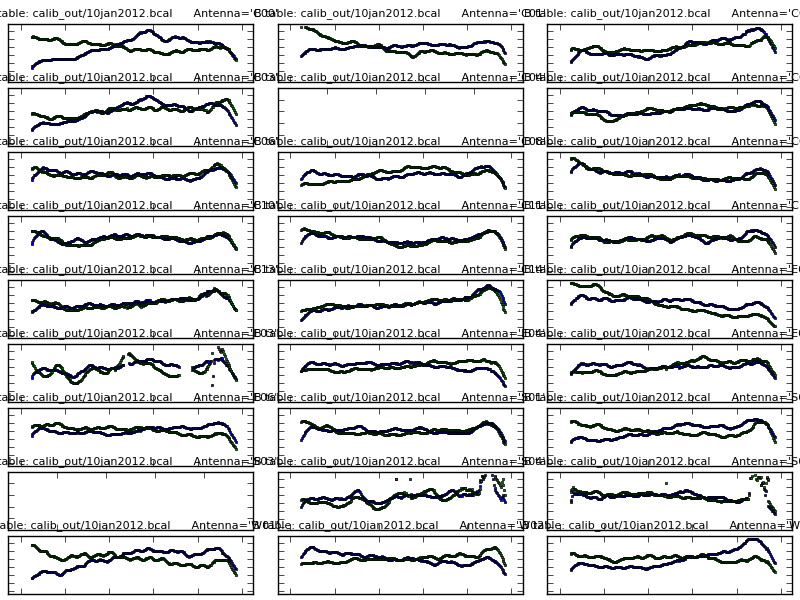

In [14]:
vis.show(outdir+'spw'+splitchannels+'_bpass.amp.png')

In [15]:
my_session.run_casa(task='casalog.post', message='Testing the command line logger.', priority='INFO', origin='Brad')

Attempting to run casalog.post(priority="INFO",origin="Brad",message="Testing the command line logger.")
Appears to have ended.


In [18]:
print " starting gaincal -> %s" % gainfile
my_session.run_casa(task='gaincal', vis=ms, caltable = gainfile, field = GainFields, spw = gainspw, 
        refant = referenceant, solint = 'inf', minblperant = 3, solnorm = 'false',  gaintype = 'G',
        combine = '', calmode = 'ap', 
        gaintable = bpassfile, gainfield = bpassfield,
        append = 'false', parang = 'true')
             
print " starting cross delay cal -> %s" % xdelfile        
my_session.run_casa(task='gaincal', vis=ms, caltable = xdelfile, field = xdelfield, spw = myspw, 
        refant = referenceant, solint = 'inf', minblperant = 3, gaintype = 'KCROSS',
        combine = 'scan', smodel = PrimaryFlux,
        gaintable = [bpassfile, gainfile], gainfield = [bpassfield, xdelfield],
        append = 'false', parang = 'true')
           
print " starting Df polcal -> %s"  % dpolfile
my_session.run_casa(task='polcal', vis=ms, caltable = dpolfile, field = dpolfield, spw = myspw, 
    refant = referenceant, solint = 'inf', minblperant = 3, combine = 'scan',
    poltype = 'Df+QU', 
    gaintable = [bpassfile, gainfile, xdelfile], 
    gainfield = [bpassfield, secondaryfield, xdelfield],
    append = 'false')

print " starting Xf polcal -> %s"  % xpolfile      
my_session.run_casa(task='polcal', vis=ms, caltable = xpolfile, field = xpolfield, spw = myspw, 
    refant = referenceant, solint = 'inf', minblperant = 3, combine = 'scan',
    poltype = 'Xf', smodel = PrimaryFlux,
    gaintable = [bpassfile, gainfile, xdelfile, dpolfile], 
    gainfield = [bpassfield, fluxfield, xdelfield, dpolfield],
    append = 'false')  
           

 starting gaincal -> calib_out/10jan2012.gcal
Attempting to run gaincal(field="0,1,1",minblperant=3,gainfield="0",solint="inf",caltable="calib_out/10jan2012.gcal",gaintable="calib_out/10jan2012.bcal",spw="0:40~216",vis="10jan2012.ms",calmode="ap",combine="",gaintype="G",parang=True,solnorm=False,refant="20",append=False)
Appears to have ended.
 starting cross delay cal -> calib_out/10jan2012.xdel
Attempting to run gaincal(field="0",minblperant=3,gainfield=['0', '0'],solint="inf",caltable="calib_out/10jan2012.xdel",smodel=[21.069, 0.21, 0.471, 0],gaintable=['calib_out/10jan2012.bcal', 'calib_out/10jan2012.gcal'],spw="0",vis="10jan2012.ms",combine="scan",gaintype="KCROSS",parang=True,refant="20",append=False)
Appears to have ended.
 starting Df polcal -> calib_out/10jan2012.pcal
Attempting to run polcal(field="1",minblperant=3,gainfield=['0', '1', '0'],solint="inf",caltable="calib_out/10jan2012.pcal",gaintable=['calib_out/10jan2012.bcal', 'calib_out/10jan2012.gcal', 'calib_out/10jan2012.

In [19]:

           
print " starting fluxscale -> %s", fluxfile 
my_session.run_casa(task='fluxscale', vis=ms, caltable = gainfile, reference = fluxfield, 
           transfer = [secondaryfield,dpolfield], fluxtable = fluxfile,
           listfile = outdir+'fluxscale.txt',
           append = 'false')         

 starting fluxscale -> %s calib_out/10jan2012.fluxscale
Attempting to run fluxscale(reference="0",caltable="calib_out/10jan2012.gcal",transfer=['1', '1'],listfile="calib_out/fluxscale.txt",vis="10jan2012.ms",fluxtable="calib_out/10jan2012.fluxscale",append=False)
Appears to have ended.


In [20]:
    
          
#-------------------------------------- Plot cal solutions
print " plotting cal solutions"
# bandpass
print " plotting bandpass solutions"
my_session.run_casa(task='plotcal', caltable = bpassfile, xaxis = 'chan', yaxis = 'amp',
            field = bpassfield, antenna = '', spw = outspw, iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+splitchannels+'_bpass.amp.png',
            markersize=3.0, plotsymbol= '.', plotrange=[-2,250,0.2,1.5], fontsize=8.0,
            plotcolor = 'blue')

my_session.run_casa(task='plotcal', caltable = bpassfile, xaxis = 'chan', yaxis = 'phase',
            field = bpassfield, antenna = '', spw = outspw, iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+splitchannels+'_bpass.phase.png',
            markersize=3.0, plotsymbol= '.', fontsize=8.0, plotcolor = 'blue')
        
# gain
print " plotting gain solutions"
my_session.run_casa(task='plotcal', caltable = fluxfile, xaxis = 'time', yaxis = 'amp',
            field = '', antenna = '', spw = '', iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+gainchannels+'_gain.amp.png',
            markersize=3.0, plotsymbol= '.', fontsize=8.0, plotcolor = 'blue')

my_session.run_casa(task= 'plotcal', caltable = fluxfile, xaxis = 'time', yaxis = 'phase',
            field = '', antenna = '', spw = '', iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+gainchannels+'_gain.phase.png',
            markersize=3.0, plotsymbol= '.', fontsize=8.0, plotcolor = 'blue')

 plotting cal solutions
 plotting bandpass solutions
Attempting to run plotcal(subplot=931,plotcolor="blue",markersize=3.0,plotrange=[-2, 250, 0.2, 1.5],antenna="",yaxis="amp",caltable="calib_out/10jan2012.bcal",figfile="calib_out/spw12~243_bpass.amp.png",iteration="antenna",spw="0:12~243",field="0",showgui=False,fontsize=8.0,xaxis="chan",plotsymbol=".")
Appears to have ended.
Attempting to run plotcal(subplot=931,plotcolor="blue",markersize=3.0,antenna="",yaxis="phase",caltable="calib_out/10jan2012.bcal",figfile="calib_out/spw12~243_bpass.phase.png",iteration="antenna",spw="0:12~243",field="0",showgui=False,fontsize=8.0,xaxis="chan",plotsymbol=".")
Appears to have ended.
 plotting gain solutions
Attempting to run plotcal(subplot=931,plotcolor="blue",markersize=3.0,antenna="",yaxis="amp",caltable="calib_out/10jan2012.fluxscale",figfile="calib_out/spw40~216_gain.amp.png",iteration="antenna",spw="",field="",showgui=False,fontsize=8.0,xaxis="time",plotsymbol=".")
Appears to have ended.
At

In [22]:
# polarization D-terms versus channel
print " plotting D-terms"
my_session.run_casa(task='plotcal', caltable = dpolfile, xaxis = 'chan', yaxis = 'amp',
            field = dpolfield, antenna = '', spw = outspw, iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+splitchannels+'_dpol.amp.png',
            markersize=3.0, plotsymbol= '.', plotrange=[-2,250,0.0,0.2], fontsize=8.0,
            plotcolor = 'blue')   

my_session.run_casa(task='plotcal', caltable = dpolfile, xaxis = 'chan', yaxis = 'phase',
            field = dpolfield, antenna = '', spw = outspw, iteration = 'antenna',
            subplot = 931, showgui = 'false', figfile = outdir+'spw'+splitchannels+'_dpol.phase.png',
            markersize=3.0, plotsymbol= '.', fontsize=8.0, plotcolor = 'blue')
        
# polarization position angle correction versus channel
print " plotting position angle solution"

my_session.run_casa(task='plotcal', caltable = xpolfile, xaxis = 'chan', yaxis = 'phase',
            field = xpolfield, antenna='', spw = outspw, iteration = 'antenna',
            subplot = 111, showgui = 'false', figfile = outdir+'spw'+splitchannels+'_xpol.png',
            markersize=5.0, plotsymbol= '.', fontsize=8.0)
        
#---------------------------------------------------
marktime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
print "Calibration solutions complete: %s" % marktime
print " Applying calibrations..."
# ---------------------------------------------------

 plotting D-terms
Attempting to run plotcal(subplot=931,plotcolor="blue",markersize=3.0,plotrange=[-2, 250, 0.0, 0.2],antenna="",yaxis="amp",caltable="calib_out/10jan2012.pcal",figfile="calib_out/spw12~243_dpol.amp.png",iteration="antenna",spw="0:12~243",field="1",showgui=False,fontsize=8.0,xaxis="chan",plotsymbol=".")
Appears to have ended.
Attempting to run plotcal(subplot=931,plotcolor="blue",markersize=3.0,antenna="",yaxis="phase",caltable="calib_out/10jan2012.pcal",figfile="calib_out/spw12~243_dpol.phase.png",iteration="antenna",spw="0:12~243",field="1",showgui=False,fontsize=8.0,xaxis="chan",plotsymbol=".")
Appears to have ended.
 plotting position angle solution
Attempting to run plotcal(subplot=111,markersize=5.0,antenna="",yaxis="phase",caltable="calib_out/10jan2012.xcal",figfile="calib_out/spw12~243_xpol.png",iteration="antenna",spw="0:12~243",field="0",showgui=False,fontsize=8.0,xaxis="chan",plotsymbol=".")
Appears to have ended.
Calibration solutions complete: Wed, 05 Apr 2

In [23]:
print " applying calibrations: primary calibrator"       
my_session.run_casa(task='applycal', vis=ms, field = fluxfield, spw = myspw, 
                    selectdata='False', calwt = 'False',
                    gaintable = [bpassfile, fluxfile, dpolfile, xdelfile, xpolfile],
                    gainfield = [bpassfield,fluxfield,dpolfield,xdelfield, xpolfield], 
                    parang = 'true')

print " applying calibrations: polarization calibrator" 
my_session.run_casa(task='applycal', vis=ms, field = dpolfield, spw = myspw, 
                    selectdata ='False', calwt = 'False',
                    gaintable = [bpassfile, fluxfile, dpolfile, xdelfile, xpolfile],
                    gainfield = [bpassfield,secondaryfield,dpolfield,xdelfield,xpolfield], 
                    parang= 'true')  
         
print " applying calibrations: secondary calibrators" 
my_session.run_casa(task='applycal', vis=ms, field = secondaryfield, spw = myspw, 
                    selectdata = 'False', calwt = 'False',
                    gaintable = [bpassfile, fluxfile, dpolfile, xdelfile, xpolfile],
                    gainfield = [bpassfield,secondaryfield,dpolfield,xdelfield, xpolfield], 
                    parang= 'true') 
            
print " applying calibrations: target fields"
for myfield in infields: 
    print " apply cal %s" % myfield
    my_session.run_casa(task='applycal', vis=ms, field = myfield, spw = myspw, 
                        selectdata = 'False', calwt = 'False',
                        gaintable = [bpassfile, fluxfile, dpolfile, xdelfile, xpolfile],
                        gainfield = [bpassfield,secondaryfield,dpolfield, xdelfield, xpolfield], 
                        parang= 'true')

marktime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())

 applying calibrations: primary calibrator
Attempting to run applycal(gainfield=['0', '0', '1', '0', '0'],field="0",gaintable=['calib_out/10jan2012.bcal', 'calib_out/10jan2012.fluxscale', 'calib_out/10jan2012.pcal', 'calib_out/10jan2012.xdel', 'calib_out/10jan2012.xcal'],spw="0",calwt=False,vis="10jan2012.ms",parang=True,selectdata=False)
Appears to have ended.
 applying calibrations: polarization calibrator
Attempting to run applycal(gainfield=['0', '1', '1', '0', '0'],field="1",gaintable=['calib_out/10jan2012.bcal', 'calib_out/10jan2012.fluxscale', 'calib_out/10jan2012.pcal', 'calib_out/10jan2012.xdel', 'calib_out/10jan2012.xcal'],spw="0",calwt=False,vis="10jan2012.ms",parang=True,selectdata=False)
Appears to have ended.
 applying calibrations: secondary calibrators
Attempting to run applycal(gainfield=['0', '1', '1', '0', '0'],field="1",gaintable=['calib_out/10jan2012.bcal', 'calib_out/10jan2012.fluxscale', 'calib_out/10jan2012.pcal', 'calib_out/10jan2012.xdel', 'calib_out/10jan2012

In [24]:
print "Calibration complete: %s" % marktime
    
# do a final flag on the calibrated visibilities  
if(postflag):   
    print " Flag run on calibrated visiblities ...."
    my_session.run_casa(task='flagdata', vis=ms,mode='rflag',freqdevscale=6.0, 
                        timedevscale = 6.0, datacolumn='CORRECTED',display='report')

#---------------------------------------------------
# now split the target fields and calibrator data to new measurement sets
print " Starting split..."
print " spec ave = %d, time ave = %s" % (specave, timeave)

#target fields
print " splitting target fields from visibility file = %s" % ms
for myfield in infields:
    print "splitting %s" % myfield
    my_session.run_casa(task='split', vis = ms, outputvis= myfield+'.ms', 
                        datacolumn = 'corrected', field = myfield,
                        spw = outspw, width = specave, timebin = timeave)
      
# calibrator field
print " splitting secondary calibrator %s from visibility file = %s" % (calname, ms)
my_session.run_casa(task='split', vis = ms, outputvis= calname+'.ms', 
                    datacolumn = 'corrected', field = secondaryfield,
                    spw = outspw, width = specave, timebin = timeave)     
          
# -----------------------------------------------------      

marktime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
print "completed spw: %s" % myspw

print "pipeline processing completed"
process_end = time.time()
duration = (process_end - process_start)/3600.0
print "Total run time: %7.2f hours" % duration

Calibration complete: Wed, 05 Apr 2017 12:35:14
 Flag run on calibrated visiblities ....
Attempting to run flagdata(timedevscale=6.0,freqdevscale=6.0,datacolumn="CORRECTED",vis="10jan2012.ms",mode="rflag",display="report")
Appears to have ended.
 Starting split...
 spec ave = 4, time ave = 5s
 splitting target fields from visibility file = 10jan2012.ms
splitting EW47
Attempting to run split(field="EW47",outputvis="EW47.ms",timebin="5s",width=4,datacolumn="corrected",spw="0:12~243",vis="10jan2012.ms")
Something's gone wrong... Check your command.
splitting EW48
Attempting to run split(field="EW48",outputvis="EW48.ms",timebin="5s",width=4,datacolumn="corrected",spw="0:12~243",vis="10jan2012.ms")
Something's gone wrong... Check your command.
splitting EW49
Attempting to run split(field="EW49",outputvis="EW49.ms",timebin="5s",width=4,datacolumn="corrected",spw="0:12~243",vis="10jan2012.ms")
Something's gone wrong... Check your command.
 splitting secondary calibrator J1549+506 from visibil

NameError: name 'process_start' is not defined

In [26]:
!ls calib_out

10jan2012.bcal	     10jan2012.xcal.plotCal	spw12~243_dpol.amp.png
10jan2012.fluxscale  10jan2012.xdel		spw12~243_dpol.phase.png
10jan2012.gcal	     fluxscale.txt		spw12~243_xpol.png
10jan2012.pcal	     spw12~243_bpass.amp.png	spw40~216_gain.amp.png
10jan2012.xcal	     spw12~243_bpass.phase.png	spw40~216_gain.phase.png


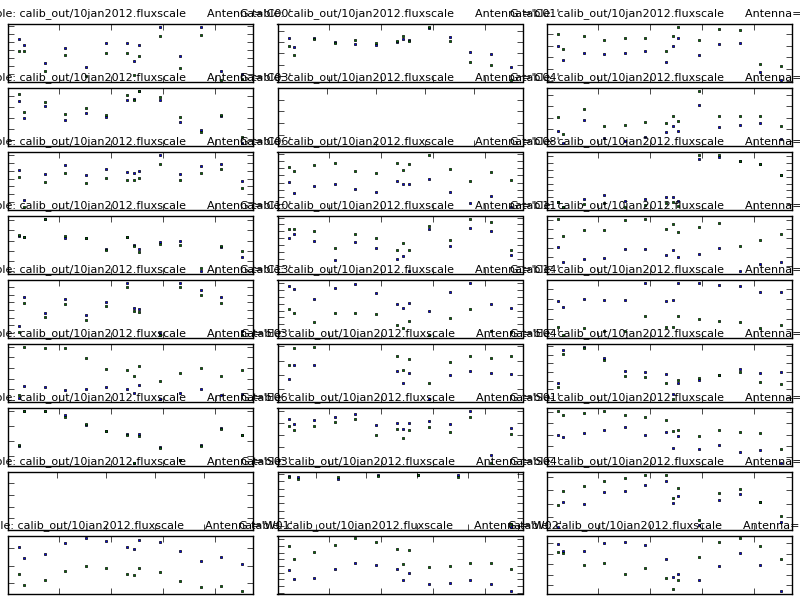

In [29]:
vis.show('calib_out/spw40~216_gain.amp.png')